# Laboratorio 05 - Autocodificadores

Integrantes:
- José Pablo Kiesling Lange, 21581
- Melissa Pérez Alarcón, 21385

### Configuración de GPU

In [18]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

### Librerías

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

### Preparación de Datos

In [20]:
# carga de datos
df = pd.read_csv('./data/UK_foods.csv')

print(df.head())

       Unnamed: 0  England  Wales  Scotland  N.Ireland
0          Cheese      105    103       103         66
1   Carcass_meat       245    227       242        267
2     Other_meat       685    803       750        586
3            Fish      147    160       122         93
4  Fats_and_oils       193    235       184        209


In [21]:
# información general del dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  17 non-null     object
 1   England     17 non-null     int64 
 2   Wales       17 non-null     int64 
 3   Scotland    17 non-null     int64 
 4   N.Ireland   17 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 808.0+ bytes
None


In [22]:
# descripción de los datos
print(df.describe())

           England        Wales     Scotland    N.Ireland
count    17.000000    17.000000    17.000000    17.000000
mean    469.647059   503.941176   460.235294   429.941176
std     452.701466   463.859282   469.595907   479.896014
min      54.000000    64.000000    53.000000    41.000000
25%     156.000000   175.000000   147.000000   135.000000
50%     253.000000   265.000000   242.000000   209.000000
75%     685.000000   803.000000   566.000000   586.000000
max    1472.000000  1582.000000  1572.000000  1506.000000


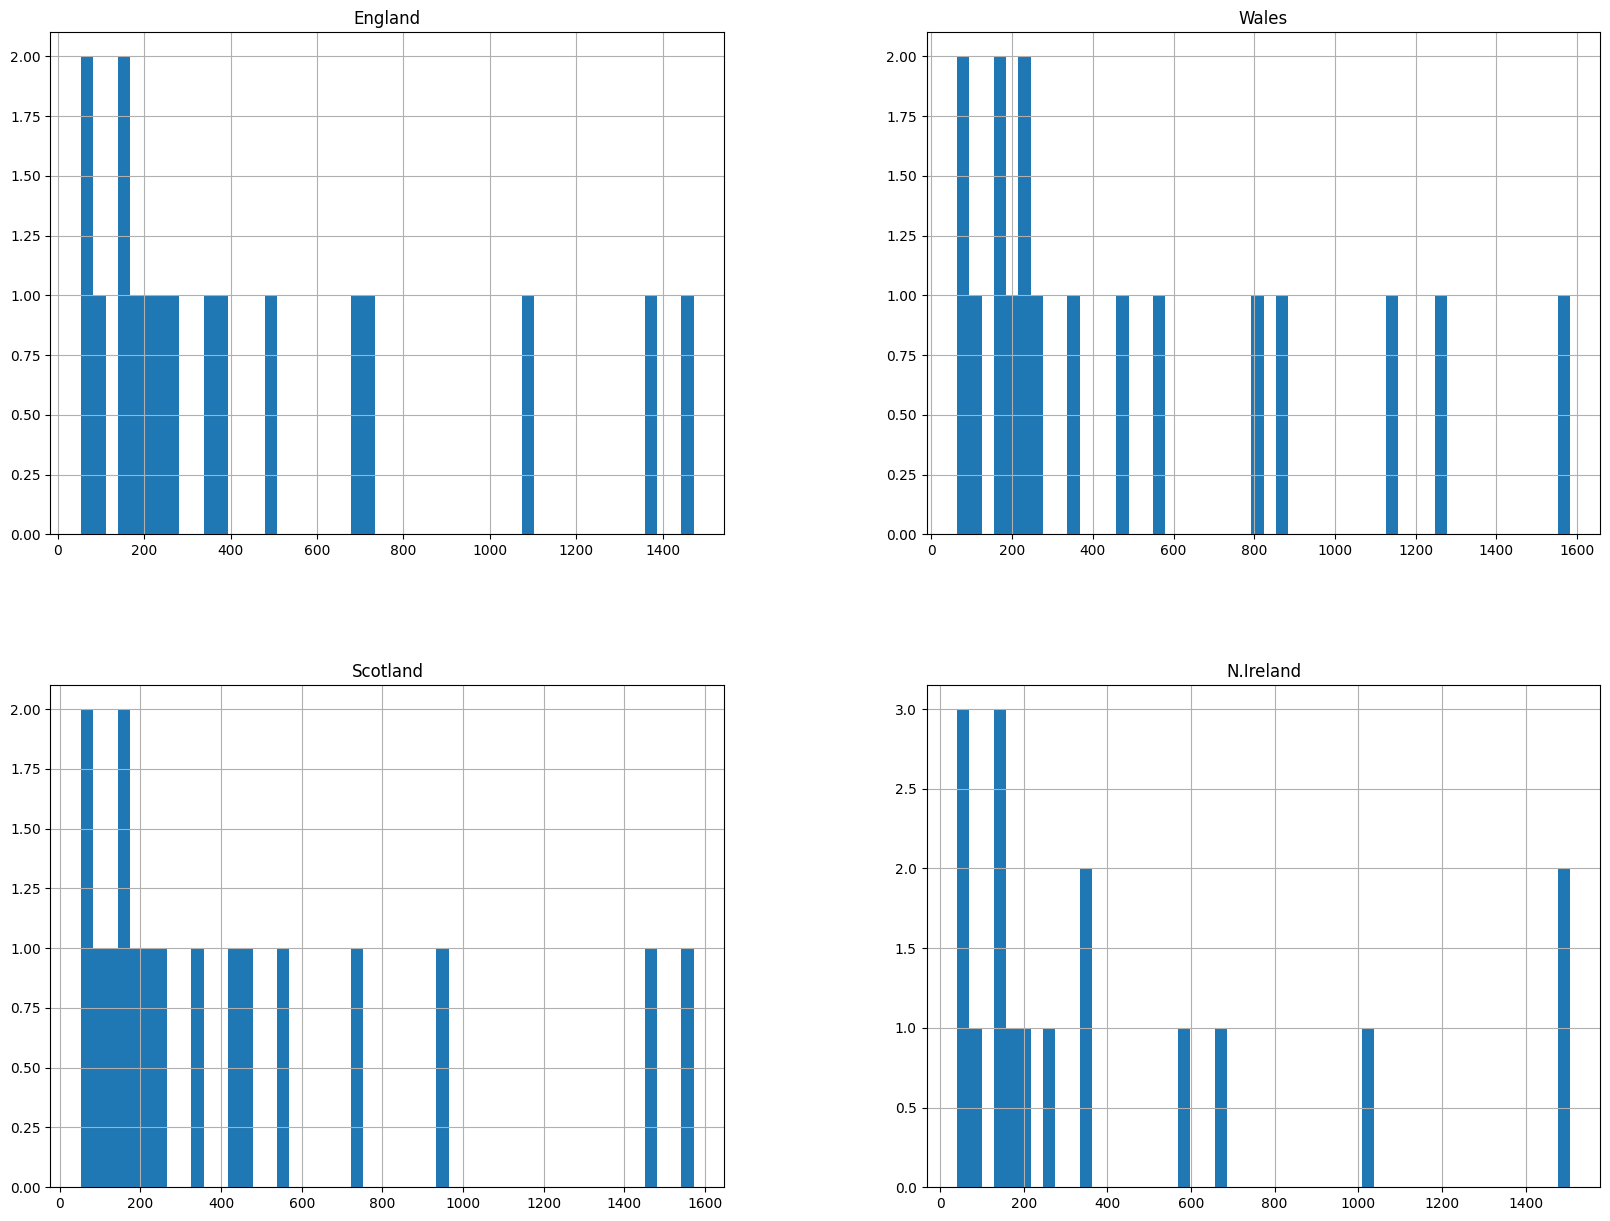

In [23]:
# histogramas de distribución de los datos
df.hist(bins=50, figsize=(20,15))
plt.show()

In [24]:
# normalización de los datos
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:])

In [25]:
print(df_scaled.head())

    England     Wales  Scotland  N.Ireland
0  0.035966  0.025692  0.032916   0.017065
1  0.134697  0.107378  0.124424   0.154266
2  0.444993  0.486825  0.458855   0.372014
3  0.065585  0.063241  0.045425   0.035495
4  0.098025  0.112648  0.086241   0.114676


#### Hallazgos en la preparación de datos
- El DataFrame tiene 17 filas y 5 columnas donde la primera es de texto y el resto numéricas.
- Las estadísticas descriptivas muestran lo siguiente:
    - El consumo medio y la desviación estándar varían, específicamente con Inglaterra y Gales porque muestran mayores consumos promedio.
    - La desviación estándar es bastante alta en todas las regiones por lo que existe una variablidad en el consumo de alimentos.
    - Los valores mínimos y máximos varían significativamente lo que demuestra diferencias significativas en cuanto a popularidad o disponibilidad de alimentos.

### Construcción del Autocodificador

In [26]:
# dimensión de los datos de entrada
input_dim = df_scaled.shape[1]

# capa de entrada
input_layer = Input(shape=(input_dim,))

# encoder
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
# capa de cuello de botella
bottleneck = Dense(2, activation='relu')(encoded)

# decoder
decoded = Dense(4, activation='relu')(bottleneck)
decoded = Dense(8, activation='relu')(decoded)

# capa de salida
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# modelo
autoencoder = Model(input_layer, output_layer)

In [27]:
# compilación del modelo
autoencoder.compile(optimizer='Adamax', loss='mse')

In [28]:
# resumen del modelo
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 40        
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                                 
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 dense_10 (Dense)            (None, 8)                 40        
                                                                 
 dense_11 (Dense)            (None, 4)                 36  

#### Estructura del modelo
- Capa de entrada con tamaño de salida de 4.
- Capas densas:
    - dense: primera capa densa con 8 neuronas usando la función de activación relu. Tiene 40 parámetros.
    - dense_1: reduce el número de neuronas a 4 con relu. Tiene 36 parámetros.
    - dense_2: es la capa de cuello de botella con 2 neuronas, los datos se comprimen a la representación más pequeña. Tiene 10 parámetros.
    - dense_3, dense_4 y dense_5: forman el decoder reduciendo las neuronas a 4.

#### Parámetros del modelo
Tiene un total de 174 parámetros entrenables para que puedan ajustarse durante el proceso de entrenamiento.

#### Funciones de activación
- ReLu: se utilizó en todas las capas, menos en la capa de salida para que aprendiera patrones complejos.
- Sigmoide: para la capa de salida y mantener los valores entre 0 y 1.

In [30]:
df_scaled = df_scaled.values

In [31]:
# entrenamiento del modelo
history = autoencoder.fit(df_scaled, df_scaled, epochs=30, batch_size=10, verbose=1)

Epoch 1/30
2/2 [==============================] - 4s 34ms/step - loss: 0.1425
Epoch 2/30
2/2 [==============================] - 0s 9ms/step - loss: 0.1424
Epoch 3/30
2/2 [==============================] - 0s 13ms/step - loss: 0.1421
Epoch 4/30
2/2 [==============================] - 0s 9ms/step - loss: 0.1420
Epoch 5/30
2/2 [==============================] - 0s 7ms/step - loss: 0.1418
Epoch 6/30
2/2 [==============================] - 0s 8ms/step - loss: 0.1416
Epoch 7/30
2/2 [==============================] - 0s 8ms/step - loss: 0.1414
Epoch 8/30
2/2 [==============================] - 0s 7ms/step - loss: 0.1412
Epoch 9/30
2/2 [==============================] - 0s 6ms/step - loss: 0.1411
Epoch 10/30
2/2 [==============================] - 0s 7ms/step - loss: 0.1409
Epoch 11/30
2/2 [==============================] - 0s 8ms/step - loss: 0.1407
Epoch 12/30
2/2 [==============================] - 0s 7ms/step - loss: 0.1405
Epoch 13/30
2/2 [==============================] - 0s 8ms/step - loss: 

In [32]:
# evaluación del modelo
loss = autoencoder.evaluate(df_scaled, df_scaled)
print("Pérdida:", loss)

1/1 [==============================] - 0s 193ms/step - loss: 0.1373
Pérdida: 0.1372896432876587


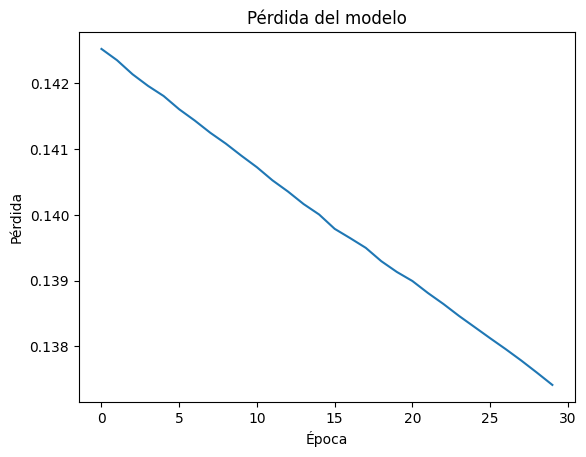

In [33]:
# visualización de la pérdida
plt.plot(history.history['loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

#### Interpretación
Durante el entrenamiento, se tuvo una pérdida entre [0.13-0.15] en las primeras épocas, luego disminuye gradualmente cerca de 0.12. Esta pérdida indica que el modelo está aprendiendo efectivamente cómo comprimir y luego reconstruir los datos en cada época de entrenamiento. 

En la gráfica puede notarse esa evolución de la pérdida que disminuye a lo largo de las épocas. Además en las últimas épocas, la pérdida parece acercarse a un valor más estable.

### Reducción de Dimensionalidad y Visualización

In [35]:
encoder = Model(input_layer, bottleneck)
encoded_data = encoder.predict(df_scaled)

1/1 [==============================] - 0s 103ms/step


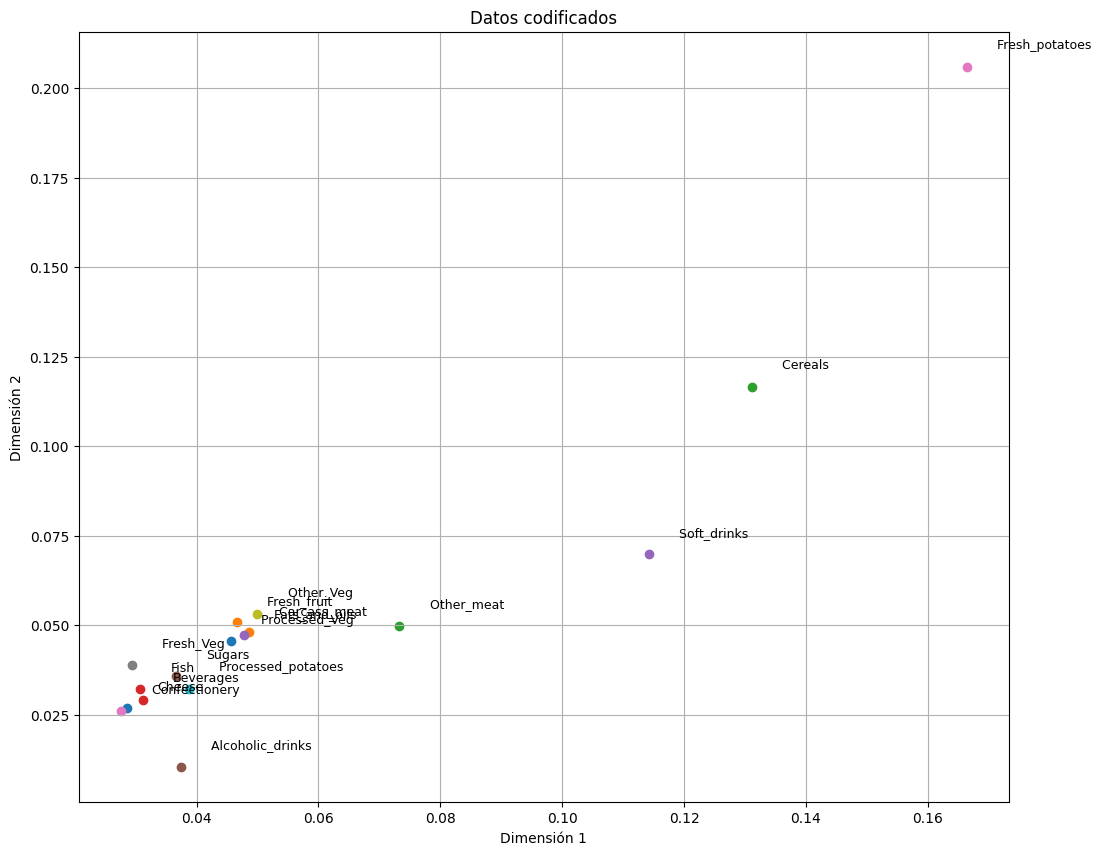

In [43]:
plt.figure(figsize=(12, 10))
for i, food in enumerate(df.iloc[:, 0]):
    plt.scatter(encoded_data[i, 0], encoded_data[i, 1])
    plt.text(encoded_data[i, 0]+0.005, encoded_data[i, 1]+0.005, food, fontsize=9)
plt.title('Datos codificados')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid(True)
plt.show()


Dimensión 1:

En esta dimensión, Fresh_potatoes y Cereals, tienen los valores más altos. Esto podría indicar que los alimentos tienen un mayor consumo. Es probable que esta dimensión esté relacionada con la popularidad de los alimentos, que se consumen en cantidades más grandes y están presentes en la dieta de la mayoría de las regiones. Por otro lado, los alimentos como Alcoholic_drinks y Confectionery, con valores más bajos, podrían representar alimentos que son menos esenciales o menos consumidos en la dieta, y cuyo consumo no varía tanto entre las regiones.

Dimensión 2:

La segunda dimensión parece mostrar preferencias en el tipo de alimento. Por ejemplo, Fresh_potatoes tiene un valor muy alto en esta dimensión, es decir que su consumo varía significativamente entre las regiones. Soft_drinks y Cereals también están separados en esta dimensión, es decir que estas categorías tienen patrones de consumo que las diferencian de otros alimentos. En contraste, los alimentos agrupados en la parte baja, como Alcoholic_drinks y Confectionery, tienen valores bajos en esta dimensión, por lo que el consumo de estos productos no varía tanto entre las diferentes regiones, o que su consumo es generalmente bajo en todas las regiones.


En resumen, las dimensiones obtenidas parecieran ser la popularidad y la variabilidad en el consumo de diferentes tipos de alimentos.

### Discusión y percepciones nuevas "Insights"

Al aplicar el autocodificador pudimos extraer insights significativos del consumo de diferentes alimentos entre los países del dataset. La representación bidimensional obtenida nos permite visualizar y analizar las similitudes y diferencias en los patrones de consumo de una manera más intuitiva.

Alimentos como Fresh_potatoes y Cereals pueden estar posicionados juntos en el espacio bidimensional, indicando que tienen patrones de consumo similares y elevados en los países analizadas. Esto indica que estos alimentos son componentes esenciales de la dieta de los países del datatset. Además, Soft_drinks y Processed_potatoes están cercanos, lo que podría indicar una preferencia compartida por alimentos procesados y bebidas azucaradas en ciertos países. Por otro lado, Fresh_potatoes aparece alejado de otros alimentos y en el dataset, Irlanda del Norte tiene un consumo alto de este alimento (1033 unidades frente a 720 en Inglaterra), reflejando así una preferencia significativa. A su vez, Alcoholic_drinks muestra un consumo más alto en Escocia (458 unidades) en comparación con otros países, lo que podría explicar su posición única en el gráfico y resaltar diferencias culturales.

Esto da lugar a que las diferencias en el consumo de ciertos alimentos podrían ser por influencias culturales y geográficas. Por ejemplo, el alto consumo de papas frescas en Irlanda del Norte puede estar ligado a la agricultura del país. Asimismo, las variaciones en el consumo de bebidas alcohólicas y no alcohólicas entre las regiones podrían indicar diferencias en preferencias dietéticas y hábitos sociales. Cabe destacar, que el consumo de alimentos procesados y bebidas azucaradas podría estar relacionado con factores socioeconómicos, donde ciertas regiones con mayor acceso o preferencia por estos productos muestran patrones de consumo elevados.

Esto conlleva a que los insights pueden ayudar a las autoridades a diseñar aspectos para mejorar la nutrición y abordar problemas de salud relacionados con la dieta en países particulares. Del mismo modo, las empresas pueden adaptar sus estrategias de marketing y distribución para satisfacer las preferencias de los países identificadas. 

Durante el entrenamiento, la pérdida disminuyó de forma constante, empezando alrededor de 0.15 y estabilizándose cerca de 0.12 después de 30 épocas. Esto indica que el modelo mejoró su capacidad para imitar los datos de entrada luego del cuello de botella a lo largo del tiempo. Un MSE de 0.12 es aceptable en el contexto de un conjunto de datos pequeño, si se tuviera un conjunto de datos más grande, se podría esperar una pérdida menor. Asimismo, la gráfica de la pérdida muestra una disminución gradual y estabilización hacia las últimas épocas, lo que indica que el modelo está convergiendo y no está sobreajustando los datos.

Además, al reducir las dimensiones, se ve que hay grupos coherentes de alimentos que se agrupan juntos en el espacio reducido. Esto sugiere que el autocodificador ha logrado capturar patrones significativos en los datos y ha reducido la dimensionalidad de manera efectiva. La capacidad de identificar patrones y diferencias entre los alimentos en el espacio reducido indica que el autocodificador retuvo información relevante. Siendo que las dos dimensiones parecen capturar variaciones importantes en los patrones de consumo entre las regiones, lo que es evidente en la separación de ciertos alimentos en el gráfico.

Basado en las métricas de pérdida y la calidad de la visualización resultante, el autocodificador desempeñó bien su función de reducir la dimensionalidad manteniendo la integridad de la información.Sin embargo, el tamaño pequeño del conjunto de datos puede limitar la capacidad del modelo para generalizar.
La ausencia de un conjunto de validación o pruebas adicionales puede limitar la evaluación completa del modelo. Se podría implementar técnicas de validación cruzada para evaluar la consistencia del modelo y prevenir el sobreajuste. Además, comparar los resultados del autocodificador con otros métodos de reducción de dimensionalidad como vimos en clase con PCA.

En conclusión el autocodificador logró reducir la dimensionalidad de los datos de manera efectiva, manteniendo información clave sobre los patrones de consumo de alimentos en las cuatro regiones del Reino Unido. Las métricas de rendimiento, especialmente la disminución y estabilización de la pérdida, apoyan la afirmación de que el modelo realizó un buen trabajo.